In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.append('src')

from manageProjections import *
from op_basis_utils import *
from plotting import *

import FiniteVolumeGroups as fvg
import pickle

import matplotlib.pyplot as plt

pTot = sp.Matrix([0,0,0])
momStr='P000'
group = fvg.elongated.D4h()

mrho = 789*0.121/197
mpi  = 0.1934
msigma = 591*0.121/197
L=24
eta=48/24
Emax=5.5
ensemble='L4848'

In [3]:
(mrho+mpi)/mpi

3.5057611850980845

In [4]:
print('rhopi   cut=2   ---> ',EN_rhopi([2,0,0],[-2,0,0],mrho,mpi,L,eta))
print('threepi cut=2 ---> ',EN_threepi([2,0,0],[-2,0,0],[0,0,0],mpi,L,eta))
print('threepi cut=2 ---> ',EN_threepi([2,0,0],[-1,0,0],[-1,0,0],mpi,L,eta))
print('threepi cut=2 ---> ',EN_threepi([1,1,1],[-1,-1,0],[-1,0,0],mpi,L,eta))

rhopi   cut=2   --->  6.575087440499638
threepi cut=2 --->  6.772232852706806
threepi cut=2 --->  6.252073649264434
threepi cut=2 --->  6.106192170044477


In [5]:
t=Timer()
t.start('rho-pi')
rhopiResults = get_rhopi_results(group,pTot,2,Emax,mrho,mpi,L,eta)
t.stop()

rho-pi: took  180.2942 seconds


In [6]:
t=Timer()
t.start('three-pi')
threepiResults = get_threepi_results(group,pTot,2,Emax,mpi,L,eta)
t.stop()

three-pi: took  2125.1821 seconds


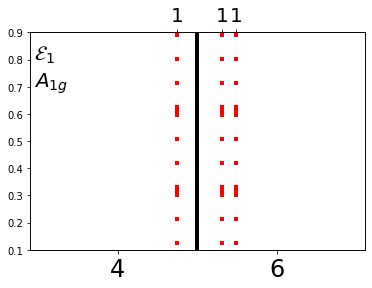

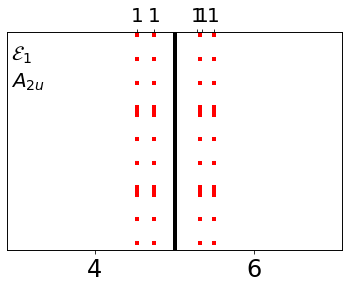

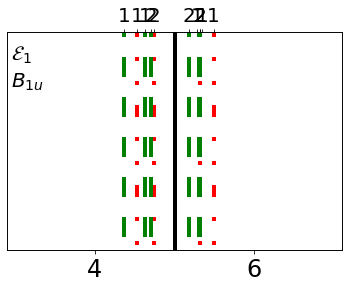

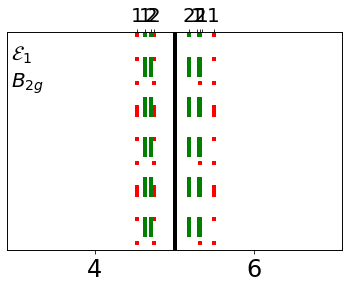

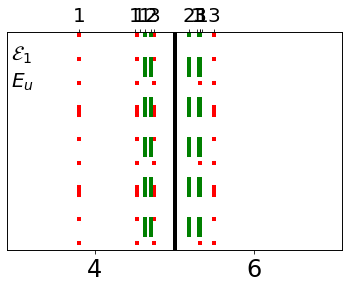

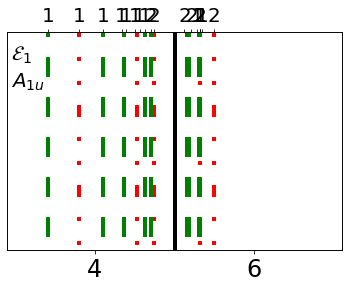

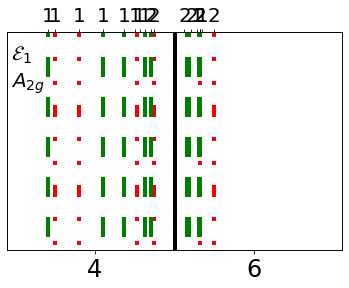

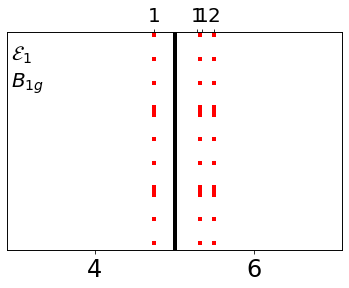

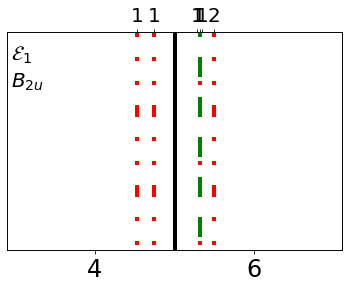

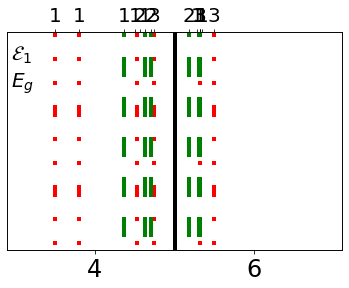

In [7]:
def latexIrrep(irrep):
    return '$' + irrep[0]+'_{' + irrep[1:] + '}$'

for irrep in group.elements[0].irreps:
#for irrep in ['T1g','Eg']:

    fig, ax = nonint_plt(rhopiResults,threepiResults,irrep)
    plt.text(2.95,0.8,'$\\mathcal{E}_1$',fontsize=20)
    plt.text(2.95,0.7,latexIrrep(irrep),fontsize=20)

    plt.show()

In [9]:
cutoff=5.4
for irrep in group.elements[0].irreps:
    allOpString = ''

    for opType in [rhopiResults]:
    #for opType in[sigmapiResults,threepiResults]:
        for seed in opType:
            if seed['E']<cutoff:
    #if seed['E']<4.5:
                new_subs = {k: v for k,v in seed['full'].vecToSymbol.items()}
                new_subs = {k: str(v) for k,v in new_subs.items()}
                new_subs = {k: sp.Symbol(str(v).replace('-','m')) for k,v in new_subs.items()}
                
                for op in getOperators(seed['full'],irrep):
                    o=sp.expand(op).subs(seed['full'].symbolToVec)
                    o=o.subs(new_subs)
                    o=opToCPP(o,swapXZ=True)
                    if o[0]=='+':
                        o=o[1:]
                    allOpString+=o+'\n'
    
    for seed in threepiResults:
        if seed['E']<cutoff:
            for op in getOperators(seed['full'],irrep):
                allOpString+=opToCPP(op.to_sympy(),swapXZ=True)+'\n'
    
    with open('OPS/'+ensemble+'/a1_'+ensemble+'_'+momStr+'_'+irrep+'_'+str(cutoff)+'_swapXZ.txt',"w") as text_file:
        text_file.write(allOpString)

In [11]:
import h5py
import os

fileDir=os.path.join("OPS","L4848")

f=h5py.File(os.path.join(fileDir,"L4848.hdf5"),"w")

def simplestr(p):
    s=""
    for i in p:
        s+='['+str(i[0])+','+str(i[1])+','+str(i[2])+']'
    return s

for irrep in group.elements[0].irreps:
    irrepGroup=f.create_group(irrep)
    opGroup=irrepGroup.create_dataset('rhopi',(len(rhopiResults),2))
    for i,o in enumerate(rhopiResults):
        opGroup[i,0]=o['E']
        opGroup[i,1]=len(getOperators(o['full'],irrep))
        #opGroup[i,2]=simplestr(o['seed'])
    
    opGroup=irrepGroup.create_dataset('threepi',(len(threepiResults),2))
    for i,o in enumerate(threepiResults):
        opGroup[i,0]=o['E']
        opGroup[i,1]=len(getOperators(o['full'],irrep))
        #opGroup[i,2]=simplestr(o['seed'])

f.close()